<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting VCB  stock price with Neural Networks (DNN only)



## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
import pandas as pd

In [4]:
data=pd.read_csv('excel_vcb.csv')

In [5]:
data.head

<bound method NDFrame.head of       time <Ticker>  <DTYYYYMMDD>   <Open>   <High>    <Low>  <Close>  \
0        0      VCB      20090630  16.2426  16.2426  16.2426  16.2426   
1        1      VCB      20090701  16.2426  17.0547  16.1072  16.3779   
2        2      VCB      20090702  16.3779  16.3779  15.5658  15.7011   
3        3      VCB      20090703  15.7011  15.7011  15.1597  15.1597   
4        4      VCB      20090706  15.1597  15.8365  15.1597  15.8365   
...    ...      ...           ...      ...      ...      ...      ...   
3459  3459      VCB      20230515  92.8000  93.0000  91.2000  91.7000   
3460  3460      VCB      20230516  91.7000  93.1000  91.3000  92.6000   
3461  3461      VCB      20230517  92.6000  93.0000  92.3000  92.8000   
3462  3462      VCB      20230518  92.8000  96.0000  92.2000  95.0000   
3463  3463      VCB      20230519  95.0000  95.0000  92.6000  93.0000   

      <Volume>  
0       294070  
1      6248390  
2      1515670  
3       899720  
4      1

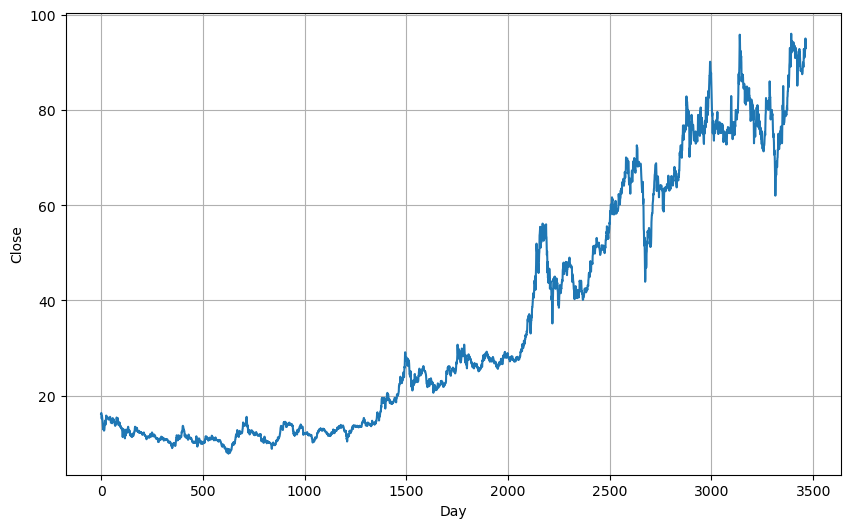

In [6]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('excel_vcb.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[6]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Day', ylabel='Close')

Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the day number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Stock Price

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3464 points in the dataset and you will use the first 3000 for training.

In [7]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

The model will be 3-layer dense network as shown below.

In [11]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [12]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 5s 38ms/step - loss: 37.8992 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 37.5104 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 37.0756 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 36.5979 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 36.0852 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 35.5467 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 34.9804 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 34.3710 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 33.7018 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 32.9604 - lr: 2.8184e-08
Epoch 11/100
93/93

93/93 [==============================] - 1s 9ms/step - loss: 0.4622 - lr: 1.4125e-04
Epoch 85/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5338 - lr: 1.5849e-04
Epoch 86/100
93/93 [==============================] - 1s 9ms/step - loss: 1.2646 - lr: 1.7783e-04
Epoch 87/100
93/93 [==============================] - 1s 8ms/step - loss: 1.3519 - lr: 1.9953e-04
Epoch 88/100
93/93 [==============================] - 1s 9ms/step - loss: 0.7379 - lr: 2.2387e-04
Epoch 89/100
93/93 [==============================] - 1s 9ms/step - loss: 1.2286 - lr: 2.5119e-04
Epoch 90/100
93/93 [==============================] - 1s 9ms/step - loss: 1.6817 - lr: 2.8184e-04
Epoch 91/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5493 - lr: 3.1623e-04
Epoch 92/100
93/93 [==============================] - 1s 8ms/step - loss: 1.2541 - lr: 3.5481e-04
Epoch 93/100
93/93 [==============================] - 1s 9ms/step - loss: 1.1840 - lr: 3.9811e-04
Epoch 94/100
93/93 [=============

(1e-08, 0.001, 0.0, 100.0)

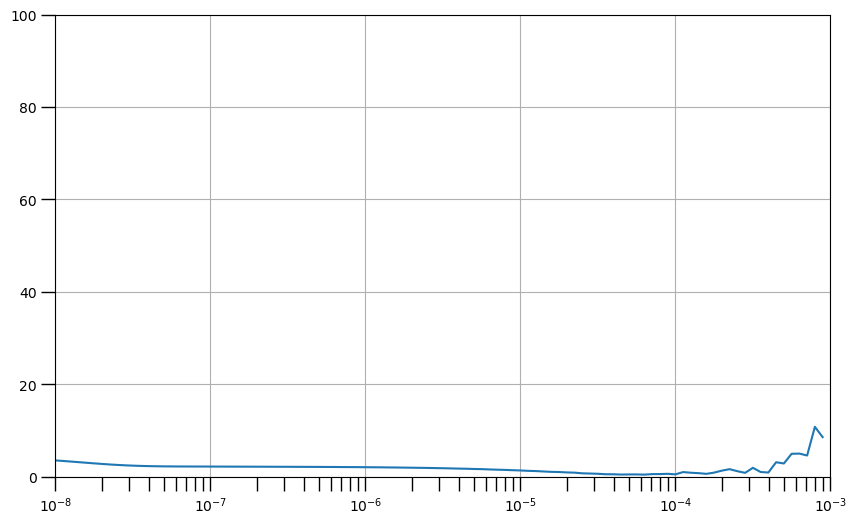

In [12]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [13]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [14]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 11ms/step - loss: 2.4061 - mse: 17.5182
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 0.9585 - mse: 4.4778
Epoch 3/100
93/93 [==============================] - 1s 10ms/step - loss: 0.8813 - mse: 3.9582
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 0.7225 - mse: 3.0116
Epoch 5/100
93/93 [==============================] - 1s 10ms/step - loss: 0.6519 - mse: 2.5225
Epoch 6/100
93/93 [==============================] - 1s 10ms/step - loss: 0.5699 - mse: 2.1138
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5450 - mse: 1.9496
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5266 - mse: 1.8683
Epoch 9/100
93/93 [==============================] - 1s 10ms/step - loss: 0.5779 - mse: 2.1853
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5860 - mse: 2.1024
Epoch 11/100
93/93 [==============================] 

93/93 [==============================] - 1s 8ms/step - loss: 0.4132 - mse: 1.2913
Epoch 88/100
93/93 [==============================] - 1s 8ms/step - loss: 0.2518 - mse: 0.6662
Epoch 89/100
93/93 [==============================] - 1s 9ms/step - loss: 0.2594 - mse: 0.7070
Epoch 90/100
93/93 [==============================] - 1s 8ms/step - loss: 0.3318 - mse: 0.9476
Epoch 91/100
93/93 [==============================] - 1s 8ms/step - loss: 0.3474 - mse: 1.0165
Epoch 92/100
93/93 [==============================] - 1s 8ms/step - loss: 0.3353 - mse: 1.0183
Epoch 93/100
93/93 [==============================] - 1s 8ms/step - loss: 0.2390 - mse: 0.6619
Epoch 94/100
93/93 [==============================] - 1s 8ms/step - loss: 0.2681 - mse: 0.7982
Epoch 95/100
93/93 [==============================] - 1s 8ms/step - loss: 0.2937 - mse: 0.8878
Epoch 96/100
93/93 [==============================] - 1s 7ms/step - loss: 0.3715 - mse: 1.0480
Epoch 97/100
93/93 [==============================] - 1s 8ms/st

## Model Prediction

Now see if the model generates good results. 

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 0s 16ms/step


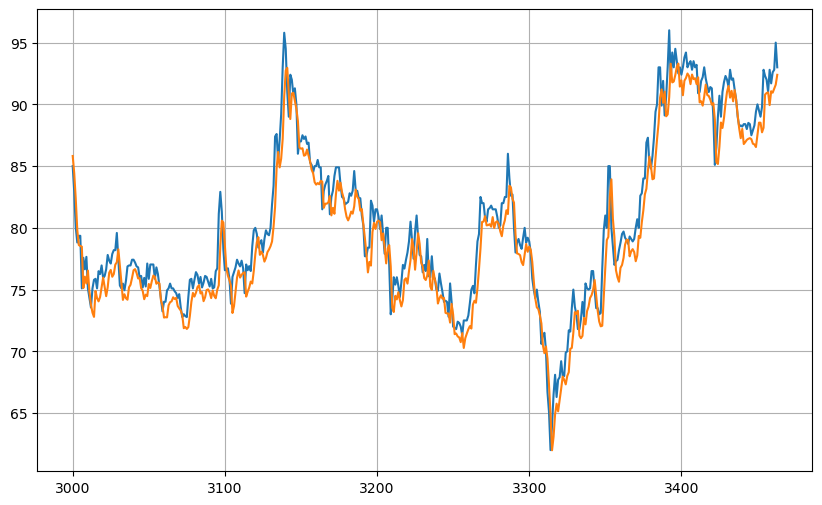

[85.81846  84.43458  82.366066 79.84199  78.606674 78.53091  78.47841
 75.12217  76.049355 75.49123  76.536354 74.809    73.773575 73.12875
 72.78862  74.88729  74.31     74.046776 74.40329  75.163376 75.96748
 75.19845  74.46787  75.184616 76.369705 76.59193  76.03917  76.25693
 77.02246  77.21635  78.25988  76.92697  75.597046 74.162735 74.622055
 74.29615  74.179596 75.18301  75.38957  75.949875 76.565834 76.6593
 76.33606  75.90074  75.9276   75.11518  74.90294  74.22061  74.590355
 74.47165  75.45386  75.1297   75.68761  76.133835 76.03806  75.46978
 75.5844   75.50552  74.12627  73.68748  72.732895 72.76521  72.747284
 73.72504  73.97857  74.04749  74.373116 74.23523  74.33234  73.67378
 73.47418  73.302635 72.929306 71.87271  71.97406  71.80986  71.96189
 72.877655 74.00986  74.729    74.43266  74.749954 75.20195  75.35806
 74.68656  74.79358  74.06087  74.37235  74.96396  75.01397  74.77509
 74.30878  74.93246  74.485435 74.29639  74.98432  75.3488   78.54387
 80.57588  80.4339

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [18]:
# Compute the MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

3.595166


## Mô hình LSTM

Trong mục này ta sẽ xây dựng mô hình LSTM để dự báo giá chứng khoán. 

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model1 = Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),  # LSTM layer với 64 đơn vị
    layers.LSTM(64, return_sequences=False),  # LSTM thứ hai
    layers.Dense(30, activation="relu"),      # Lớp Dense với 30 đơn vị
    layers.Dense(10, activation="relu"),      # Lớp Dense với 10 đơn vị
    layers.Dense(1)                           # Lớp đầu ra
])

# Compile mô hình
model1.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

In [30]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model1.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 7s 66ms/step - loss: 400.6337 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 7s 71ms/step - loss: 400.6295 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 7s 70ms/step - loss: 400.6238 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 7s 68ms/step - loss: 400.6172 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 7s 67ms/step - loss: 400.6098 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 6s 66ms/step - loss: 400.6012 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 7s 74ms/step - loss: 400.5918 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 7s 68ms/step - loss: 400.5809 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 6s 63ms/step - loss: 400.5684 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 14s 144ms/step - loss: 400.5545 - lr: 2.8184e-

93/93 [==============================] - 6s 62ms/step - loss: 60.9446 - lr: 1.1220e-04
Epoch 83/100
93/93 [==============================] - 6s 59ms/step - loss: 46.2286 - lr: 1.2589e-04
Epoch 84/100
93/93 [==============================] - 6s 60ms/step - loss: 33.6991 - lr: 1.4125e-04
Epoch 85/100
93/93 [==============================] - 6s 59ms/step - loss: 23.8295 - lr: 1.5849e-04
Epoch 86/100
93/93 [==============================] - 10s 101ms/step - loss: 16.9599 - lr: 1.7783e-04
Epoch 87/100
93/93 [==============================] - 12s 123ms/step - loss: 10.9382 - lr: 1.9953e-04
Epoch 88/100
93/93 [==============================] - 11s 107ms/step - loss: 7.6154 - lr: 2.2387e-04
Epoch 89/100
93/93 [==============================] - 10s 94ms/step - loss: 4.2678 - lr: 2.5119e-04
Epoch 90/100
93/93 [==============================] - 8s 80ms/step - loss: 2.9576 - lr: 2.8184e-04
Epoch 91/100
93/93 [==============================] - 6s 62ms/step - loss: 2.4340 - lr: 3.1623e-04
Epoch 92/1

In [26]:
history = model1.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 16s 70ms/step - loss: 1332.7510
Epoch 2/100
93/93 [==============================] - 7s 66ms/step - loss: 1317.3204
Epoch 3/100
93/93 [==============================] - 6s 63ms/step - loss: 1306.4581
Epoch 4/100
93/93 [==============================] - 6s 58ms/step - loss: 1297.5323
Epoch 5/100
93/93 [==============================] - 6s 64ms/step - loss: 1289.0344
Epoch 6/100
93/93 [==============================] - 7s 69ms/step - loss: 1278.3525
Epoch 7/100
93/93 [==============================] - 7s 67ms/step - loss: 1267.4521
Epoch 8/100
93/93 [==============================] - 6s 60ms/step - loss: 1258.2439
Epoch 9/100
93/93 [==============================] - 6s 65ms/step - loss: 1247.3693
Epoch 10/100
93/93 [==============================] - 6s 60ms/step - loss: 1235.0421
Epoch 11/100
93/93 [==============================] - 6s 63ms/step - loss: 1220.0775
Epoch 12/100
93/93 [==============================] - 7s 67ms/step - loss

93/93 [==============================] - 11s 121ms/step - loss: 414.1520
Epoch 99/100
93/93 [==============================] - 9s 84ms/step - loss: 408.6045
Epoch 100/100
93/93 [==============================] - 9s 91ms/step - loss: 403.0973


15/15 [==============================] - 1s 32ms/step


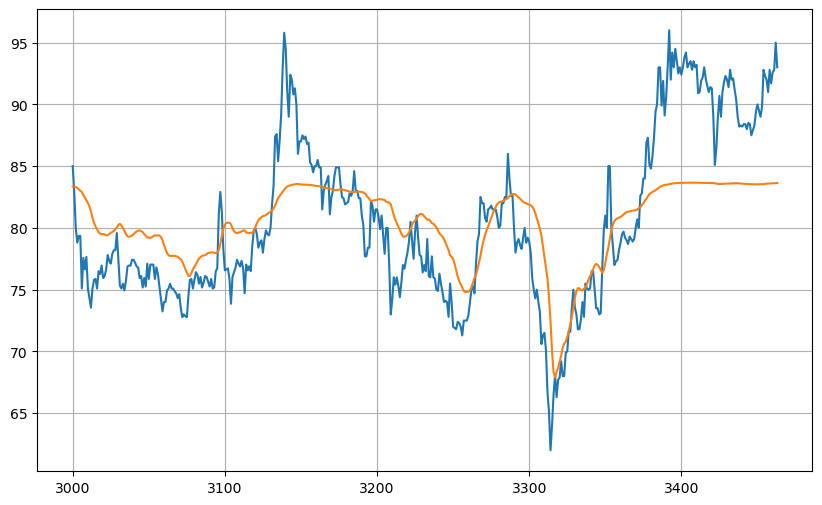

[83.36456  83.35437  83.31847  83.237854 83.12266  83.00807  82.89547
 82.65539  82.45263  82.22318  82.0354   81.73564  81.33369  80.8273
 80.42021  80.12176  79.90085  79.65603  79.55494  79.48974  79.508514
 79.46173  79.40843  79.40089  79.50695  79.60024  79.66191  79.76672
 79.89639  80.02468  80.24025  80.32787  80.20769  79.98825  79.76664
 79.50424  79.31988  79.28437  79.31787  79.38152  79.49844  79.62514
 79.72487  79.77862  79.80358  79.742096 79.66504  79.49744  79.37907
 79.21785  79.23156  79.18989  79.2424   79.32086  79.40444  79.381165
 79.40243  79.38613  79.265945 79.01439  78.61732  78.27004  77.960556
 77.79929  77.727455 77.74053  77.74147  77.73941  77.70923  77.652214
 77.54611  77.46441  77.27505  76.96966  76.67393  76.3883   76.12854
 76.11464  76.3492   76.64493  76.84665  77.062675 77.31199  77.51986
 77.62839  77.74153  77.76641  77.79822  77.88007  77.96541  78.00926
 77.99923  78.02835  77.995255 77.95296  78.03922  78.18581  78.697464
 79.36504  79.92

In [32]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model1, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)

In [33]:
forecast = []
for time in range(len(x_valid) - window_size):
    forecast.append(model1.predict(x_valid[time:time + window_size][np.newaxis]))

forecast = np.array(forecast).squeeze()

# Cắt bỏ phần đầu không cần thiết
results = forecast[split_time - window_size:]

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step


In [35]:
# Compute the MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [0] vs. [464] [Op:SquaredDifference]

sLSTM

In [36]:
class sLSTMCell(tf.keras.layers.LSTMCell):
    def __init__(self, units, **kwargs):
        super(sLSTMCell, self).__init__(units, **kwargs)
    
    def call(self, inputs, states, training=None):
        # Lấy các giá trị trạng thái và đầu vào
        h_tm1 = states[0]  # Trạng thái ẩn tại thời điểm t-1
        c_tm1 = states[1]  # Trạng thái ô nhớ tại thời điểm t-1
        
        # Tính toán cho các cổng trong sLSTM
        z = tf.matmul(inputs, self.kernel) + tf.matmul(h_tm1, self.recurrent_kernel)
        z = z + self.bias

        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Cổng quên: Sử dụng hàm mũ cơ số e
        forget_gate = tf.exp(z0)

        # Cổng đầu vào: Sử dụng hàm mũ cơ số e
        input_gate = tf.exp(z1)

        # Đầu vào của ô nhớ (Cell Input)
        cell_input = tf.tanh(z2)

        # Cổng đầu ra: Vẫn sử dụng sigmoid
        output_gate = tf.sigmoid(z3)

        # Trạng thái ô nhớ (Cell State)
        c_t = forget_gate * c_tm1 + input_gate * cell_input

        # Trạng thái ẩn (Hidden State)
        h_t = output_gate * tf.tanh(c_t)

        return h_t, [h_t, c_t]


In [37]:
# Sử dụng lớp sLSTMCell với 64 đơn vị
model2 = Sequential([
    layers.RNN(sLSTMCell(64), return_sequences=True, input_shape=[None, 1]),
    layers.RNN(sLSTMCell(64), return_sequences=False),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
])

# Compile mô hình
model2.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
history = model2.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 13s 70ms/step - loss: nan
Epoch 2/100
93/93 [==============================] - 7s 69ms/step - loss: nan
Epoch 3/100
93/93 [==============================] - 7s 74ms/step - loss: nan
Epoch 4/100
93/93 [==============================] - 6s 65ms/step - loss: nan
Epoch 5/100
93/93 [==============================] - 8s 79ms/step - loss: nan
Epoch 6/100
93/93 [==============================] - 10s 97ms/step - loss: nan
Epoch 7/100
93/93 [==============================] - 8s 78ms/step - loss: nan
Epoch 8/100
93/93 [==============================] - 7s 73ms/step - loss: nan
Epoch 9/100
93/93 [==============================] - 7s 70ms/step - loss: nan
Epoch 10/100
93/93 [==============================] - 7s 66ms/step - loss: nan
Epoch 11/100
93/93 [==============================] - 8s 85ms/step - loss: nan
Epoch 12/100
93/93 [==============================] - 11s 111ms/step - loss: nan
Epoch 13/100
93/93 [==============================] - 7s 

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model2, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)